<a href="https://colab.research.google.com/github/mmaghajani/recommender-with-tf-sample/blob/main/recomm_movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MovieLens Recommender System

In [1]:
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 3.9MB 4.0MB/s 


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
ratings_dataset, ratings_datasets_info = tfds.load(
    name='movielens/100k-ratings',
    with_info=True,
    split='train',
)

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


In [4]:
assert isinstance(ratings_dataset, tf.data.Dataset)

In [5]:
len(ratings_dataset)

100000

In [6]:
ratings_dataset_head = ratings_dataset.take(5)

for rating in ratings_dataset_head.as_numpy_iterator():
  print(rating)

{'bucketized_user_age': 45.0, 'movie_genres': array([7]), 'movie_id': b'357', 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)", 'raw_user_age': 46.0, 'timestamp': 879024327, 'user_gender': True, 'user_id': b'138', 'user_occupation_label': 4, 'user_occupation_text': b'doctor', 'user_rating': 4.0, 'user_zip_code': b'53211'}
{'bucketized_user_age': 25.0, 'movie_genres': array([ 4, 14]), 'movie_id': b'709', 'movie_title': b'Strictly Ballroom (1992)', 'raw_user_age': 32.0, 'timestamp': 875654590, 'user_gender': True, 'user_id': b'92', 'user_occupation_label': 5, 'user_occupation_text': b'entertainment', 'user_rating': 2.0, 'user_zip_code': b'80525'}
{'bucketized_user_age': 18.0, 'movie_genres': array([4]), 'movie_id': b'412', 'movie_title': b'Very Brady Sequel, A (1996)', 'raw_user_age': 24.0, 'timestamp': 882075110, 'user_gender': True, 'user_id': b'301', 'user_occupation_label': 17, 'user_occupation_text': b'student', 'user_rating': 4.0, 'user_zip_code': b'55439'}
{'bucketized_use

In [7]:
len(ratings_dataset_head)

5

In [8]:
tfds.as_dataframe(ds=ratings_dataset_head, ds_info=ratings_datasets_info)

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,7 (Drama),b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4 (doctor/health care),b'doctor',4.0,b'53211'
1,25.0,4 (Comedy)14 (Romance),b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5 (entertainment),b'entertainment',2.0,b'80525'
2,18.0,4 (Comedy),b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17 (student),b'student',4.0,b'55439'
3,50.0,5 (Crime)7 (Drama),b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4 (doctor/health care),b'healthcare',4.0,b'06472'
4,50.0,10 (Horror)16 (Thriller),b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18 (technician/engineer),b'technician',3.0,b'75094'


### Feature Selection

In [9]:
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
        'movie_title': rating['movie_title'],
        'user_rating': rating['user_rating'],
        'timestamp': rating['timestamp'],

    }
)

tfds.as_dataframe(ds=ratings_dataset.take(5), ds_info=ratings_datasets_info)

,movie_id,movie_title,timestamp,user_id,user_rating
0,b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",879024327,b'138',4.0
1,b'709',b'Strictly Ballroom (1992)',875654590,b'92',2.0
2,b'412',"b'Very Brady Sequel, A (1996)'",882075110,b'301',4.0
3,b'56',b'Pulp Fiction (1994)',883326919,b'60',4.0
4,b'895',b'Scream 2 (1997)',891409199,b'197',3.0


### What is Dataset Metadata?

In [10]:
ratings_datasets_info

tfds.core.DatasetInfo(
    name='movielens',
    full_name='movielens/100k-ratings/0.1.0',
    description="""
    This dataset contains a set of movie ratings from the MovieLens website, a movie
    recommendation service. This dataset was collected and maintained by [GroupLens]
    (https://grouplens.org/), a research group at the University of Minnesota. There
    are 5 versions included: "25m", "latest-small", "100k", "1m", "20m". In all
    datasets, the movies data and ratings data are joined on "movieId". The 25m
    dataset, latest-small dataset, and 20m dataset contain only movie data and
    rating data. The 1m dataset and 100k dataset contain demographic data in
    addition to movie and rating data.
    
    - "25m": This is the latest stable version of the MovieLens dataset. It is
    recommended for research purposes.
    - "latest-small": This is a small subset of the latest version of the MovieLens
    dataset. It is changed and updated over time by GroupLens.
    - "10

In [11]:
ratings_datasets_info.splits['train'].num_examples

100000

### Train/Test split

In [12]:
tf.random.set_seed(42)
ratings_dataset_shuffled = ratings_dataset.shuffle(
    buffer_size=100_000,
    seed=42,
    reshuffle_each_iteration=False,
)

In [13]:
ratings_trainset = ratings_dataset_shuffled.take(80_000)
ratings_testset = ratings_dataset_shuffled.skip(80_000)

In [14]:
len(ratings_trainset), len(ratings_testset)

(80000, 20000)

### End-to-End Preprocessing

In [15]:
timestamp_normalization_layer = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
timestamp_normalization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['timestamp']
    )
)

In [16]:
for rating in ratings_trainset.take(3).as_numpy_iterator():
  print(rating['timestamp'])
  print(timestamp_normalization_layer(rating['timestamp']))

885409515
tf.Tensor(0.3526018, shape=(), dtype=float32)
883388887
tf.Tensor(-0.026022714, shape=(), dtype=float32)
891249586
tf.Tensor(1.4468869, shape=(), dtype=float32)


In [17]:
user_id_lookup_layer = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['user_id']
    )
)

In [18]:
print(
    user_id_lookup_layer.get_vocabulary(),
)

['[UNK]', '405', '655', '13', '450', '276', '303', '416', '537', '234', '393', '181', '429', '279', '682', '846', '308', '378', '293', '94', '92', '7', '222', '435', '417', '201', '880', '561', '592', '796', '59', '896', '406', '758', '334', '551', '474', '130', '889', '804', '642', '268', '727', '363', '650', '194', '269', '151', '916', '387', '648', '399', '145', '749', '524', '291', '90', '864', '311', '747', '457', '299', '85', '385', '286', '374', '497', '805', '716', '327', '271', '653', '301', '883', '833', '18', '95', '389', '328', '532', '178', '506', '894', '437', '184', '881', '870', '533', '280', '339', '314', '1', '666', '472', '788', '707', '504', '798', '313', '886', '244', '62', '606', '500', '373', '343', '454', '345', '932', '782', '109', '892', '711', '588', '354', '487', '207', '774', '790', '660', '43', '622', '618', '407', '6', '87', '868', '535', '305', '425', '495', '456', '144', '102', '919', '843', '643', '49', '854', '409', '312', '851', '807', '346', '256', 

In [19]:
print(
    user_id_lookup_layer(
        ['-2', '13', '655']
    )
)

tf.Tensor([0 3 2], shape=(3,), dtype=int64)


In [20]:
user_id_embedding_dim = 32
user_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=user_id_lookup_layer.vocab_size(),
    output_dim=user_id_embedding_dim,
)
user_id_model = tf.keras.Sequential([
    user_id_lookup_layer,
    user_id_embedding_layer,                                      
])

In [21]:
user_id_model(['-2', '13'])

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[ 0.01645621, -0.00589932, -0.01471175, -0.00355174, -0.04663396,
         0.01846724,  0.02401174,  0.03724445, -0.02736737, -0.02768031,
        -0.01896119,  0.02223358, -0.03668128,  0.00480639,  0.00746088,
         0.03996835, -0.04905364,  0.00212307,  0.01345445, -0.03006717,
         0.02294225,  0.00458346, -0.03924345,  0.01767061,  0.01602763,
        -0.01630496,  0.01014177, -0.02893742,  0.03527372, -0.00593783,
         0.04485276, -0.02624741],
       [ 0.04355587, -0.04048269, -0.04138212,  0.01247839, -0.01294935,
         0.00139042,  0.01233207,  0.03024682, -0.03334862, -0.02790955,
         0.01242272, -0.04128085,  0.04214266,  0.04348017,  0.01045523,
        -0.00205957, -0.03556986, -0.01739997,  0.04255753,  0.02757342,
         0.0136765 ,  0.01282351, -0.01459817, -0.00855327, -0.03894869,
        -0.0358853 , -0.03112409,  0.01894793,  0.02213276, -0.02511839,
         0.00912381, -0.00024097]], dtyp

In [22]:
movie_id_lookup_layer = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
movie_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_id']
    )
)

In [23]:
print(
    movie_id_lookup_layer.get_vocabulary(),
)

['[UNK]', '50', '181', '100', '286', '288', '258', '294', '1', '174', '300', '121', '127', '7', '98', '56', '172', '117', '237', '222', '313', '204', '405', '210', '173', '168', '748', '151', '79', '257', '69', '195', '302', '423', '269', '118', '9', '276', '15', '22', '328', '202', '96', '64', '318', '234', '216', '176', '275', '183', '25', '111', '89', '28', '191', '12', '357', '82', '135', '238', '196', '742', '97', '268', '289', '186', '153', '125', '70', '132', '323', '11', '185', '333', '245', '483', '228', '197', '546', '194', '475', '144', '655', '568', '182', '496', '180', '179', '273', '301', '265', '161', '282', '211', '95', '8', '71', '678', '471', '322', '143', '215', '187', '427', '235', '588', '271', '250', '88', '508', '597', '435', '603', '4', '403', '385', '208', '298', '284', '272', '175', '134', '474', '307', '200', '515', '527', '479', '230', '147', '393', '209', '340', '99', '83', '23', '13', '58', '566', '274', '419', '14', '124', '326', '24', '732', '327', '229'

In [24]:
movie_id_embedding_dim = 32
movie_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=movie_id_lookup_layer.vocab_size(),
    output_dim=movie_id_embedding_dim,
)
movie_id_model = tf.keras.Sequential([
    movie_id_lookup_layer,
    movie_id_embedding_layer,                                      
])

In [25]:
movie_id_model(['181'])

Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.03616878,  0.04707202,  0.01779593,  0.00641242,  0.01253701,
         0.03653159, -0.03389543, -0.03889864,  0.01164722,  0.0103556 ,
         0.01303868,  0.00213008,  0.03186623, -0.02943003, -0.03095821,
        -0.03535131, -0.0350804 ,  0.03594816,  0.04167328,  0.00044954,
         0.03656684,  0.02033374,  0.00343715, -0.01490697,  0.01331348,
         0.03415987, -0.00653956, -0.02034122,  0.0349067 , -0.02944384,
        -0.01097735,  0.009092  ]], dtype=float32)>

In [26]:
movie_title_vectorization_layer = tf.keras.layers.experimental.preprocessing.TextVectorization()
movie_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_title']
    )
)

In [27]:
print(
    movie_title_vectorization_layer.get_vocabulary(),
)

['', '[UNK]', 'the', '1996', '1997', '1995', '1994', 'of', '1993', 'and', 'a', 'in', '1989', '1992', 'star', 'to', '1990', '1991', '1986', 'day', '1982', 'man', 'trek', '1981', '1984', 'for', '1987', '1980', 'dead', '1979', 'with', '1974', 'one', 'liar', '1988', 'lost', '1985', '2', 'my', '1998', 'first', 'contact', '1971', '1977', 'monty', '1983', 'love', 'on', 'last', 'men', 'back', 'die', 'seven', 'you', '1975', 'hard', 'life', 'i', '1963', 'ii', 'chocolate', 'air', 'return', 'la', 'story', 'home', 'godfather', 'terminator', '1962', 'scream', 'about', 'wars', '1939', 'bride', '1967', '1940', '1954', 'it', 'good', 'batman', 'when', '1957', 'time', 'night', 'jedi', 'alien', 'by', 'lies', '1941', 'fear', 'fargo', 'english', 'red', 'patient', 'mrs', '1951', 'full', 'kiss', 'blade', 'under', 'toy', 'do', '1972', 'king', 'mr', 'kill', 'dogs', '1959', '1968', 'raiders', 'devils', 'ark', 'rock', 'park', 'force', 'american', 'fire', '1970', 'jurassic', 'independence', 'id4', '1958', 'black',

In [28]:
print(movie_title_vectorization_layer("One Flew Over the Cuckoo's Nest (1975)"))

tf.Tensor([ 32 263 161   2 264 261  54], shape=(7,), dtype=int64)


In [29]:
movie_title_dim = 32
movie_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(movie_title_vectorization_layer.get_vocabulary()),
    output_dim=movie_title_dim,
)

In [30]:
movie_title_model = tf.keras.Sequential([
    movie_title_vectorization_layer,
    movie_title_embedding_layer,   
    tf.keras.layers.GlobalAveragePooling1D(),                   
])

In [31]:
for row in ratings_trainset.batch(1).map(lambda rating: rating['movie_title']).take(1):
  print(row)
  print(
      movie_title_model(row)
  )

tf.Tensor([b'Postman, The (1997)'], shape=(1,), dtype=string)
tf.Tensor(
[[ 0.00361157 -0.00578593  0.02365372 -0.0215577  -0.00023236  0.01234391
   0.01664073  0.02454189 -0.00141137  0.01506065  0.00597042 -0.00238616
  -0.00226315 -0.01363194 -0.02674721 -0.00756612 -0.00199012 -0.00153668
   0.02953116 -0.01368486 -0.00472493 -0.02577673  0.00767968  0.00963355
  -0.00997955 -0.02343567 -0.00185709  0.01237489 -0.02431385  0.02289037
   0.01436726  0.00792939]], shape=(1, 32), dtype=float32)


### Query and Candidate using Two-Tower

In [32]:
query_tower = user_id_model
candidate_tower = movie_id_model

In [33]:
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

retrieval_ratings_testset = ratings_testset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

In [34]:
!pip install -q tensorflow-recommenders

     |████████████████████████████████| 81kB 2.5MB/s 


In [35]:
import tensorflow_recommenders as tfrs

In [36]:
movies_dataset, movies_dataset_info = tfds.load(
    name='movielens/100k-movies',
    split='train',
    with_info=True,
)

print(tfds.as_dataframe(movies_dataset, movies_dataset_info))

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.
     movie_genres movie_id                      movie_title
0             [4]  b'1681'           b'You So Crazy (1994)'
1          [4, 7]  b'1457'   b'Love Is All There Is (1996)'
2          [1, 3]   b'500'          b'Fly Away Home (1996)'
3             [0]   b'838'  b'In the Line of Duty 2 (1987)'
4             [7]  b'1648'       b'Niagara, Niagara (1997)'
...           ...      ...                              ...
1677          [4]  b'1611'     b'Intimate Relations (1996)'
1678         [16]  b'1125'         b'Innocents, The (1961)'
1679          [4]   b'824'  b'Great White Hype, The (1996)'
1680          [7]  b'1354'          b'Venice/Venice (1992)'
1681         [18]   b'593'             b'Stalingrad (1993)'

[1682 rows x 3 columns]


In [37]:
candidates_corpus = movies_dataset.map(
    lambda movie: movie['movie_id']
)
print(tfds.as_dataframe(candidates_corpus, movies_dataset_info))

             
0     b'1681'
1     b'1457'
2      b'500'
3      b'838'
4     b'1648'
...       ...
1677  b'1611'
1678  b'1125'
1679   b'824'
1680  b'1354'
1681   b'593'

[1682 rows x 1 columns]


In [38]:
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=candidates_corpus.batch(128).map(
            candidate_tower
        )
    ),
)

In [39]:
class RetrievalModel(tfrs.models.Model):
  def __init__(self, query_model, candidate_model, retrieval_layer):
    super().__init__()
    self.query_model = query_model
    self.candidate_model = candidate_model
    self.retrieval_layer = retrieval_layer

  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    positive_candidate_embeddings = self.candidate_model(features['movie_id'])
    loss = self.retrieval_layer(query_embeddings, positive_candidate_embeddings)
    return loss

In [40]:
retrieval_model = RetrievalModel(query_tower, candidate_tower, retrieval_task_layer)
retrieval_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1),

)

In [46]:
retrieval_ratings_trainset = retrieval_ratings_trainset.shuffle(100_000).batch(8192).cache()
retrieval_ratings_testset = retrieval_ratings_testset.batch(4096).cache()
history = retrieval_model.fit(
    retrieval_ratings_trainset,
    epochs=5,
    validation_data=retrieval_ratings_testset,
    validation_freq=1,
)

Epoch 1/5
10/10 [==============================] - 33s 3s/step - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0021 - factorized_top_k/top_10_categorical_accuracy: 0.0060 - factorized_top_k/top_50_categorical_accuracy: 0.0620 - factorized_top_k/top_100_categorical_accuracy: 0.1362 - loss: 69845.9538 - regularization_loss: 0.0000e+00 - total_loss: 69845.9538 - val_factorized_top_k/top_1_categorical_accuracy: 0.0022 - val_factorized_top_k/top_5_categorical_accuracy: 0.0170 - val_factorized_top_k/top_10_categorical_accuracy: 0.0342 - val_factorized_top_k/top_50_categorical_accuracy: 0.1565 - val_factorized_top_k/top_100_categorical_accuracy: 0.2749 - val_loss: 28803.4648 - val_regularization_loss: 0.0000e+00 - val_total_loss: 28803.4648
Epoch 2/5
10/10 [==============================] - 29s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0146 - factorized_top_k/top_10_

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

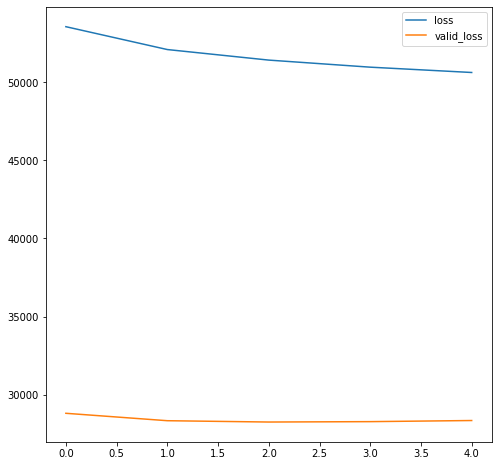

In [52]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))

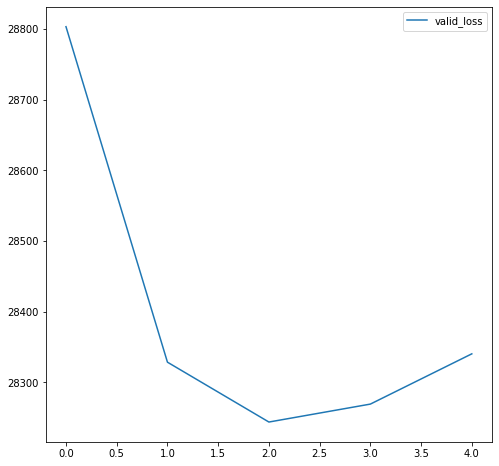

In [53]:
pd.DataFrame({
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))

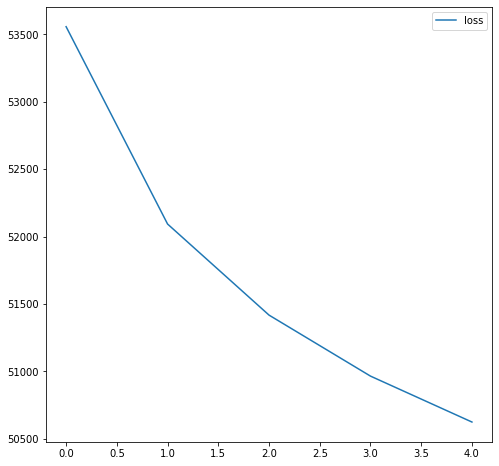

In [54]:
pd.DataFrame({
              'loss':history.history['loss'],
              }).plot(figsize=(8, 8))